# Tutorial: Yeast TYE7 bulk calling cards data

In this tutorial, we analyze a calling card experiment that mapped the binding of the yeast transcription factor TYE7. The dataset is from [Shively CA, PNAS. (2020)](https://www.pnas.org/doi/10.1073/pnas.1818015116?url_ver=Z39.88-2003&rfr_id=ori:rid:crossref.org&rfr_dat=cr_pub%20%200pubmed) and can be downloaded from [GEO](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE134427). One of the main findings of that paper was that Tye7p cooperatively binds with the transcription factor Gcr2p.  Here we will analyze Tye7p binding in wild-type and gcr2 KO cells.

In this tutorial, we will call peaks, annotate them, and perform a differential peak analysis. 

In [1]:
import pycallingcards as cc
import numpy as np
import pandas as pd
import scanpy as sc
from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 150

We start by reading in a abed datafile. Because this data was published several years ago, the data is in the old format: one row is one insertion and columns indicate the chromosome, start point and read number. Thus, we first convert it to the new file format.

Use ```cc.rd.read_qbed(filename)``` to read your own qbed data.

In [2]:
TYE7 = cc.rd.read_qbed("https://github.com/The-Mitra-Lab/pycallingcards_data/releases/download/data/GSM3946397_TEF1p_TYE7_ALL.gnashy.txt")
TYE7

,Chr,Start,End,Reads,Direction,Barcodes
0,1,1501,111,NaN,NaN,NaN
1,1,1502,1,NaN,NaN,NaN
2,1,5320,1,NaN,NaN,NaN
3,1,5544,199,NaN,NaN,NaN
4,1,32962,1,NaN,NaN,NaN
...,...,...,...,...,...,...
11450,16,928369,1,NaN,NaN,NaN
11451,16,928381,14,NaN,NaN,NaN
11452,16,928555,34,NaN,NaN,NaN
11453,16,930647,330,NaN,NaN,NaN


In [3]:
TYE7_gcr2ko = cc.rd.read_qbed("https://github.com/The-Mitra-Lab/pycallingcards_data/releases/download/data/GSM3946398_TEF1p_TYE7_gcr2ko_ALL.gnashy.txt")
TYE7_gcr2ko

,Chr,Start,End,Reads,Direction,Barcodes
0,1,3108,1,NaN,NaN,NaN
1,1,8064,9,NaN,NaN,NaN
2,1,30957,2,NaN,NaN,NaN
3,1,30989,1,NaN,NaN,NaN
4,1,31530,1,NaN,NaN,NaN
...,...,...,...,...,...,...
12283,16,930468,2,NaN,NaN,NaN
12284,16,930698,13,NaN,NaN,NaN
12285,16,936191,4,NaN,NaN,NaN
12286,16,938479,3,NaN,NaN,NaN


Define a function to transfer data to new version.

In [4]:
def transfer(data):
    for i in range(len(data)):
        data.iloc[i,3] = data.iloc[i,2]
        data.iloc[i,2] = data.iloc[i,1] + 1
        num = data.iloc[i,0]
        if num == 1:
            data.iloc[i,0] = 'chrI'
        elif num == 2:
            data.iloc[i,0] = 'chrII'
        elif num == 3:
            data.iloc[i,0] = 'chrIII'
        elif num == 4:
            data.iloc[i,0] = 'chrIV'
        elif num == 5:
            data.iloc[i,0] = 'chrV'
        elif num == 6:
            data.iloc[i,0] = 'chrVI'
        elif num == 7:
            data.iloc[i,0] = 'chrVII'
        elif num == 8:
            data.iloc[i,0] = 'chrVIII'
        elif num == 9:
            data.iloc[i,0] = 'chrIX'  
        elif num == 10:
            data.iloc[i,0] = 'chrX'
        elif num == 11:
            data.iloc[i,0] = 'chrXI'
        elif num == 12:
            data.iloc[i,0] = 'chrXII'
        elif num == 13:
            data.iloc[i,0] = 'chrXIII'
        elif num == 14:
            data.iloc[i,0] = 'chrXIV'
        elif num == 15:
            data.iloc[i,0] = 'chrXV'
        elif num == 16:
            data.iloc[i,0] = 'chrXVI'
    return data

In [5]:
TYE7 = transfer(TYE7)
TYE7['group'] = 'TYE7'
TYE7

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chrI,1501,1502,111.0,NaN,NaN,TYE7
1,chrI,1502,1503,1.0,NaN,NaN,TYE7
2,chrI,5320,5321,1.0,NaN,NaN,TYE7
3,chrI,5544,5545,199.0,NaN,NaN,TYE7
4,chrI,32962,32963,1.0,NaN,NaN,TYE7
...,...,...,...,...,...,...,...
11450,chrXVI,928369,928370,1.0,NaN,NaN,TYE7
11451,chrXVI,928381,928382,14.0,NaN,NaN,TYE7
11452,chrXVI,928555,928556,34.0,NaN,NaN,TYE7
11453,chrXVI,930647,930648,330.0,NaN,NaN,TYE7


In [6]:
TYE7_gcr2ko = transfer(TYE7_gcr2ko)
TYE7_gcr2ko['group'] = 'TYE7_gcr2ko'
TYE7_gcr2ko

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chrI,3108,3109,1.0,NaN,NaN,TYE7_gcr2ko
1,chrI,8064,8065,9.0,NaN,NaN,TYE7_gcr2ko
2,chrI,30957,30958,2.0,NaN,NaN,TYE7_gcr2ko
3,chrI,30989,30990,1.0,NaN,NaN,TYE7_gcr2ko
4,chrI,31530,31531,1.0,NaN,NaN,TYE7_gcr2ko
...,...,...,...,...,...,...,...
12283,chrXVI,930468,930469,2.0,NaN,NaN,TYE7_gcr2ko
12284,chrXVI,930698,930699,13.0,NaN,NaN,TYE7_gcr2ko
12285,chrXVI,936191,936192,4.0,NaN,NaN,TYE7_gcr2ko
12286,chrXVI,938479,938480,3.0,NaN,NaN,TYE7_gcr2ko


In order to call differential peaks, we conbine two qbed files together.

In [7]:
qbed_data = cc.rd.combine_qbed([TYE7, TYE7_gcr2ko])
qbed_data

,Chr,Start,End,Reads,Direction,Barcodes,group
0,chrI,1501,1502,111.0,NaN,NaN,TYE7
1,chrI,1502,1503,1.0,NaN,NaN,TYE7
2,chrI,1557,1558,304.0,NaN,NaN,TYE7_gcr2ko
3,chrI,1687,1688,8.0,NaN,NaN,TYE7_gcr2ko
4,chrI,1690,1691,7.0,NaN,NaN,TYE7_gcr2ko
...,...,...,...,...,...,...,...
23738,chrXVI,939075,939076,120.0,NaN,NaN,TYE7_gcr2ko
23739,chrXVI,939536,939537,22.0,NaN,NaN,TYE7
23740,chrXVI,940225,940226,1.0,NaN,NaN,TYE7_gcr2ko
23741,chrXVI,941830,941831,116.0,NaN,NaN,TYE7_gcr2ko


Because insertions are discrete, we now need to call peaks to deduce potential binding sites. Three different methods (*CCcaller, MACCS, Blockify*) are available along with three different species (*hg38, mm10, sacCer3*). 

Because of the particularity of yeast calling cards data, we use ***MACCS*** in *yeast*('sacCer3') data. *window_size* is the most important parameter for *MACCS*, it is highly related to the length of a peak. 100-200 is a good fit for *window_size*. *step_size* is another important paramenter and it controls how careful we are at looking into the chromosomes. 30-100 is good for *step_size*. *pvalue_cutoff* is also an important parameter and numbers below 0.1 are strongly advised.


In [8]:
peak_data = cc.pp.call_peaks(qbed_data, method = "MACCS", reference = "sacCer3", extend = 50, window_size = 125,
                             step_size = 60, pvalue_cutoff = 0.1, lam_win_size = None, pseudocounts = 0, 
                             record = True, save = "peak.bed")
peak_data

For the MACCS method without background, [expdata, reference, pvalue_cutoff, lam_win_size, window_size, step_size, extend, pseudocounts, test_method, min_insertions, record] would be utilized.


100%|██████████| 16/16 [00:01<00:00,  9.36it/s]


,Chr,Start,End,Center,pvalue,Experiment Insertions,Reference Insertions,Fraction Experiment,TPH Experiment,Expect insertions,pvalue_adj
0,chrI,67951,68693,68291.0,2.642331e-14,48,51,0.002022,2.021648e+05,13.115174,2.022960e-11
1,chrI,70943,71502,71275.0,0.000000e+00,61,45,0.002569,2.569178e+05,11.572212,0.000000e+00
2,chrI,189451,189651,189576.0,3.775548e-10,7,0,0.000295,2.948237e+04,0.257160,2.454985e-07
3,chrI,189841,189991,189928.0,2.047280e-04,7,6,0.000295,2.948237e+04,1.542962,6.073639e-02
4,chrI,229669,230027,229883.0,0.000000e+00,58,57,0.002443,2.442825e+05,14.658135,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...
159,chrXVI,502731,502939,502850.0,5.347856e-07,10,5,0.000421,4.211768e+04,1.495148,2.350432e-04
160,chrXVI,810436,810625,810568.0,3.224670e-06,6,2,0.000253,2.527061e+04,0.598059,1.308251e-03
161,chrXVI,855654,856341,855836.0,0.000000e+00,623,12,0.026239,2.623931e+06,3.588356,0.000000e+00
162,chrXVI,927958,928521,928300.5,5.686336e-08,45,62,0.001895,1.895295e+05,18.539841,3.032734e-05


In order to choose the suitable method and parameters for peak calling, please take a look at genome areas. We stongly advise to adjust the parameters for ```cc.pp.call_peaks()``` to call better peaks.

In this plot, the colored ones are the experiment qbed data and the middle section is the distribution of insertions. The bottom section represents reference genes and peaks. 

In yeast, one peak might be divided into two and the true binding site is in the middle space. Thus, please carefully modify the *window_size* and *step_size* parameters.

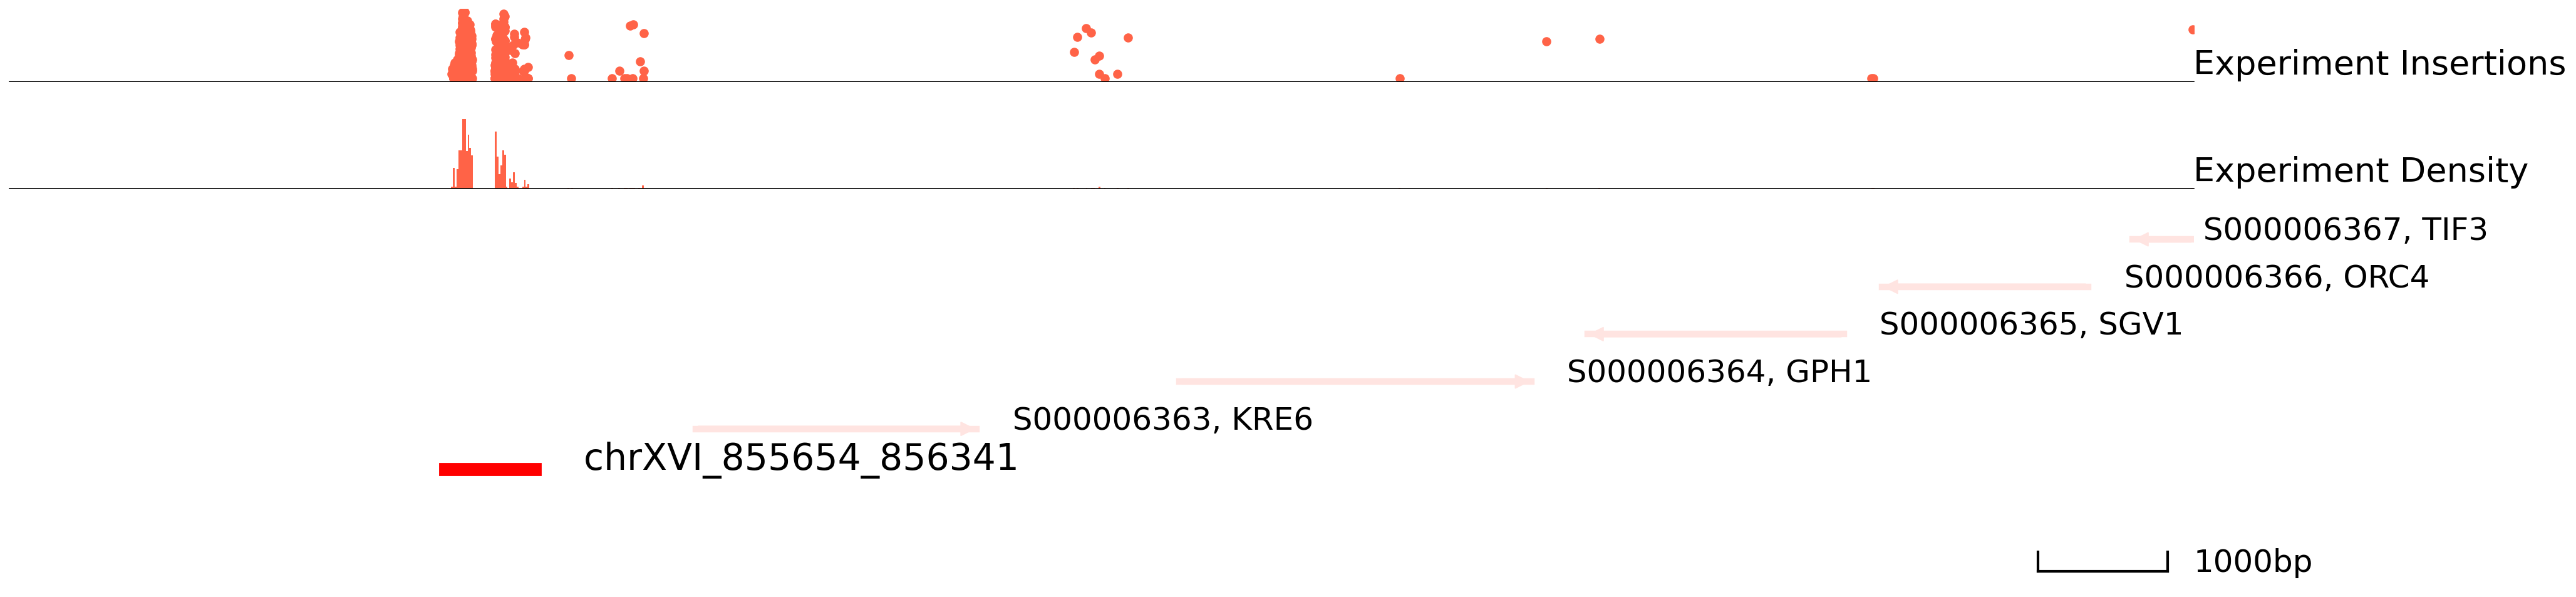

In [9]:
cc.pl.draw_area("chrXVI", 860297, 861116, 8000, peak_data, qbed_data, "sacCer3", font_size=2,
                figsize = (30,8), peak_line = 1, save = False, plotsize = [1,1,5], example_length = 1000)

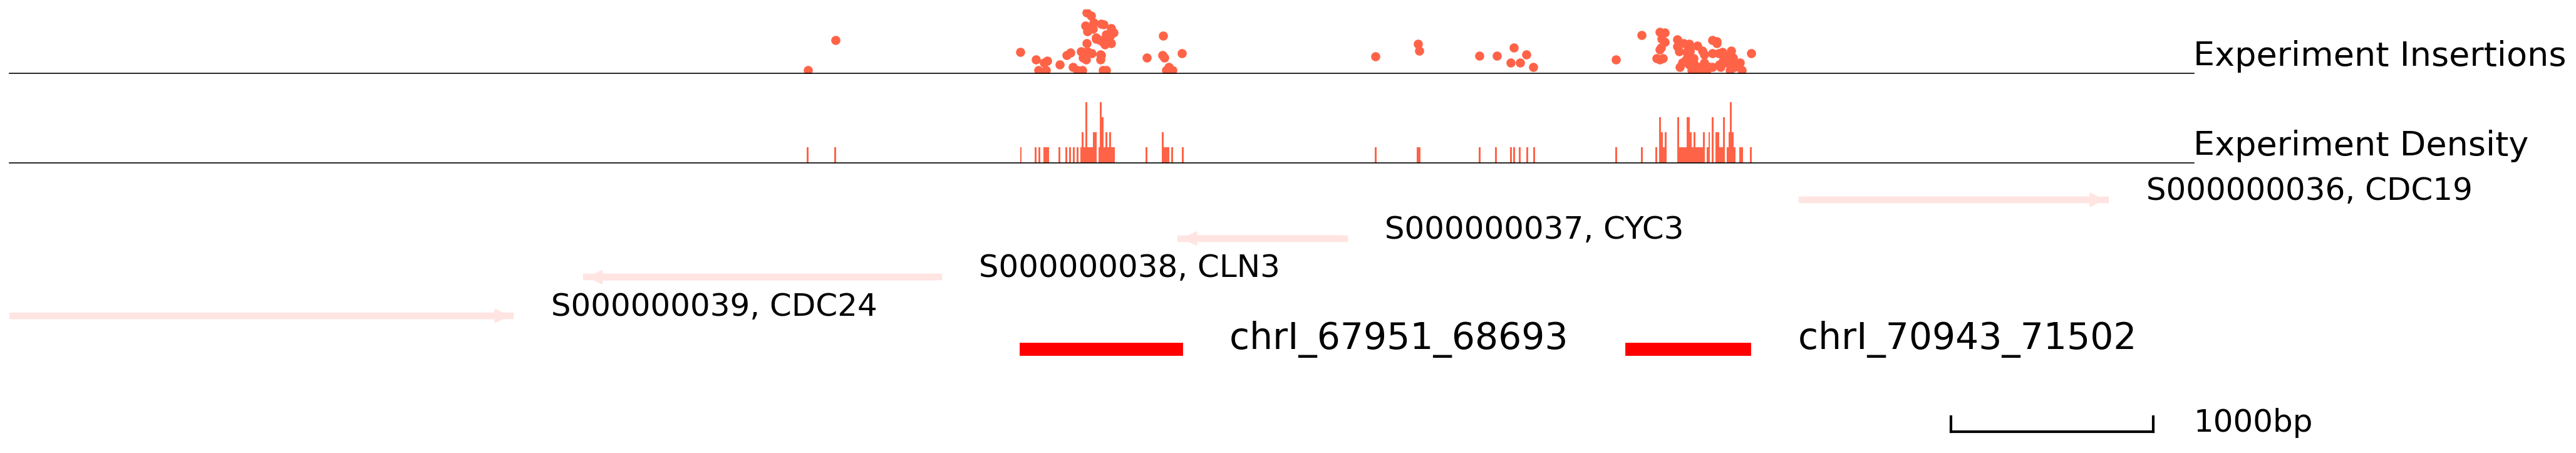

In [10]:
cc.pl.draw_area("chrI", 68926, 67722, 6000, peak_data, qbed_data, "sacCer3", font_size=2,
                figsize = (30,6), peak_line = 1, save = False, plotsize = [1,1,4], example_length = 1000)

We can also visualize our data directly in the [WashU Epigenome Browser](http://epigenomegateway.wustl.edu/browser/). This can be useful for overlaying your data with other published datasets. Please note that this link only valid for 24hrs, so you will have to rerun it if you want to use it after this time period.

For bedgraph file, it is aimed to show the distribution of qbed data. Please set the the **Aggregate method** of bedgraph file to *count* or *sum* and fix the *Y-axis* if you want to compare several datasets.

In [11]:
qbed= {"TYE7":TYE7, "TYE7_gcr2ko":TYE7_gcr2ko}
bed = {'PEAK':peak_data}
cc.pl.WashU_browser_url(qbed, bed, genome = 'sacCer3')

All qbed addressed
All bed addressed
Uploading files
Please click the following link to see the data on WashU Epigenome Browser directly.
https://epigenomegateway.wustl.edu/browser/?genome=sacCer3&hub=https://companion.epigenomegateway.org//task/1520360f75b2fd95bb3a5d8b7a4a0ec7/output//datahub.json


Pycallingcards can be used to visual peak locations acorss the genome to see that the distribution of peaks is unbiased and that all chromosomes are represented.

In [12]:
cc.pl.whole_peaks(peak_data, reference = 'sacCer3', height_scale = 1.7)

In the next step, we annotate the peaks by their closest genes using [bedtools](https://bedtools.readthedocs.io/en/latest/) and [pybedtools](https://daler.github.io/pybedtools/).
Make sure they are all previously installed before using.

In [13]:
peak_annotation = cc.pp.annotation(peak_data, reference = 'sacCer3')
peak_annotation = cc.pp.combine_annotation(peak_data, peak_annotation)
peak_annotation

In the bedtools method, we would use bedtools in the default path. Set bedtools path by 'bedtools_path' if needed.


,Chr,Start,End,Center,pvalue,Experiment Insertions,Reference Insertions,Fraction Experiment,TPH Experiment,Expect insertions,pvalue_adj,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
0,chrI,67951,68693,68291.0,2.642331e-14,48,51,0.002022,2.021648e+05,13.115174,2.022960e-11,S000000037,CYC3,S000000038,CLN3
1,chrI,70943,71502,71275.0,0.000000e+00,61,45,0.002569,2.569178e+05,11.572212,0.000000e+00,S000000036,CDC19,S000000037,CYC3
2,chrI,189451,189651,189576.0,3.775548e-10,7,0,0.000295,2.948237e+04,0.257160,2.454985e-07,S000000080,YAT1,S000000079,MST28
3,chrI,189841,189991,189928.0,2.047280e-04,7,6,0.000295,2.948237e+04,1.542962,6.073639e-02,S000000080,YAT1,S000000079,MST28
4,chrI,229669,230027,229883.0,0.000000e+00,58,57,0.002443,2.442825e+05,14.658135,0.000000e+00,S000000094,PHO11,S000000084,FLO1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159,chrXVI,502731,502939,502850.0,5.347856e-07,10,5,0.000421,4.211768e+04,1.495148,2.350432e-04,S000005947,SKS1,S000005945,RMI1
160,chrXVI,810436,810625,810568.0,3.224670e-06,6,2,0.000253,2.527061e+04,0.598059,1.308251e-03,S000006342,MEP3,S000006344,TAZ1
161,chrXVI,855654,856341,855836.0,0.000000e+00,623,12,0.026239,2.623931e+06,3.588356,0.000000e+00,S000006363,KRE6,S000006364,GPH1
162,chrXVI,927958,928521,928300.5,5.686336e-08,45,62,0.001895,1.895295e+05,18.539841,3.032734e-05,S000006398,OPT2,S000006397,HPA2


Use qbed data, peak data and group names to make a group by peak anndata object.

In [14]:
adata_cc = cc.pp.make_Anndata(qbed_data, peak_annotation, ['TYE7', 'TYE7_gcr2ko'], key = 'group', reference = "sacCer3")
adata_cc

100%|██████████| 16/16 [00:00<00:00, 148.82it/s]


AnnData object with n_obs × n_vars = 2 × 164
    var: 'Chr', 'Start', 'End', 'Center', 'pvalue', 'Experiment Insertions', 'Reference Insertions', 'Fraction Experiment', 'TPH Experiment', 'Expect insertions', 'pvalue_adj', 'Nearest Refseq1', 'Gene Name1', 'Nearest Refseq2', 'Gene Name2'

Differential peak analysis would find out the significant binding for each group. In this example, we use *fisher exact test* to find out.

In [15]:
cc.tl.rank_peak_groups(adata_cc, "Index", method = 'fisher_exact', key_added = 'fisher_exact')

100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


Plot the results for differential peak analysis.

Currently, the peaks are ranked by pvalues. It could also be ranked by logfoldchanges by the following codes:

```python
cc.tl.rank_peak_groups(adata_cc,"Index",method = 'fisher_exact',key_added = 'fisher_exact',rankby = 'logfoldchanges')
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact',rankby = 'logfoldchanges')

```

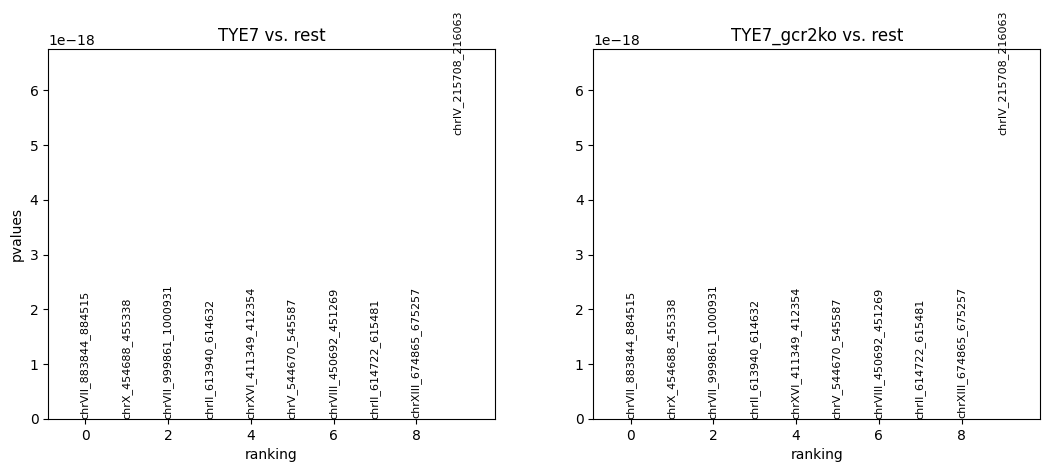

In [16]:
cc.pl.rank_peak_groups(adata_cc, key = 'fisher_exact')

Then, we take a look at the genome for highly differentiated peaks. The colored ones are the insertions for specific cluster and the grey ones are the total insertions information. If we input the backgound file, the grey ones would be the backgound insertions.

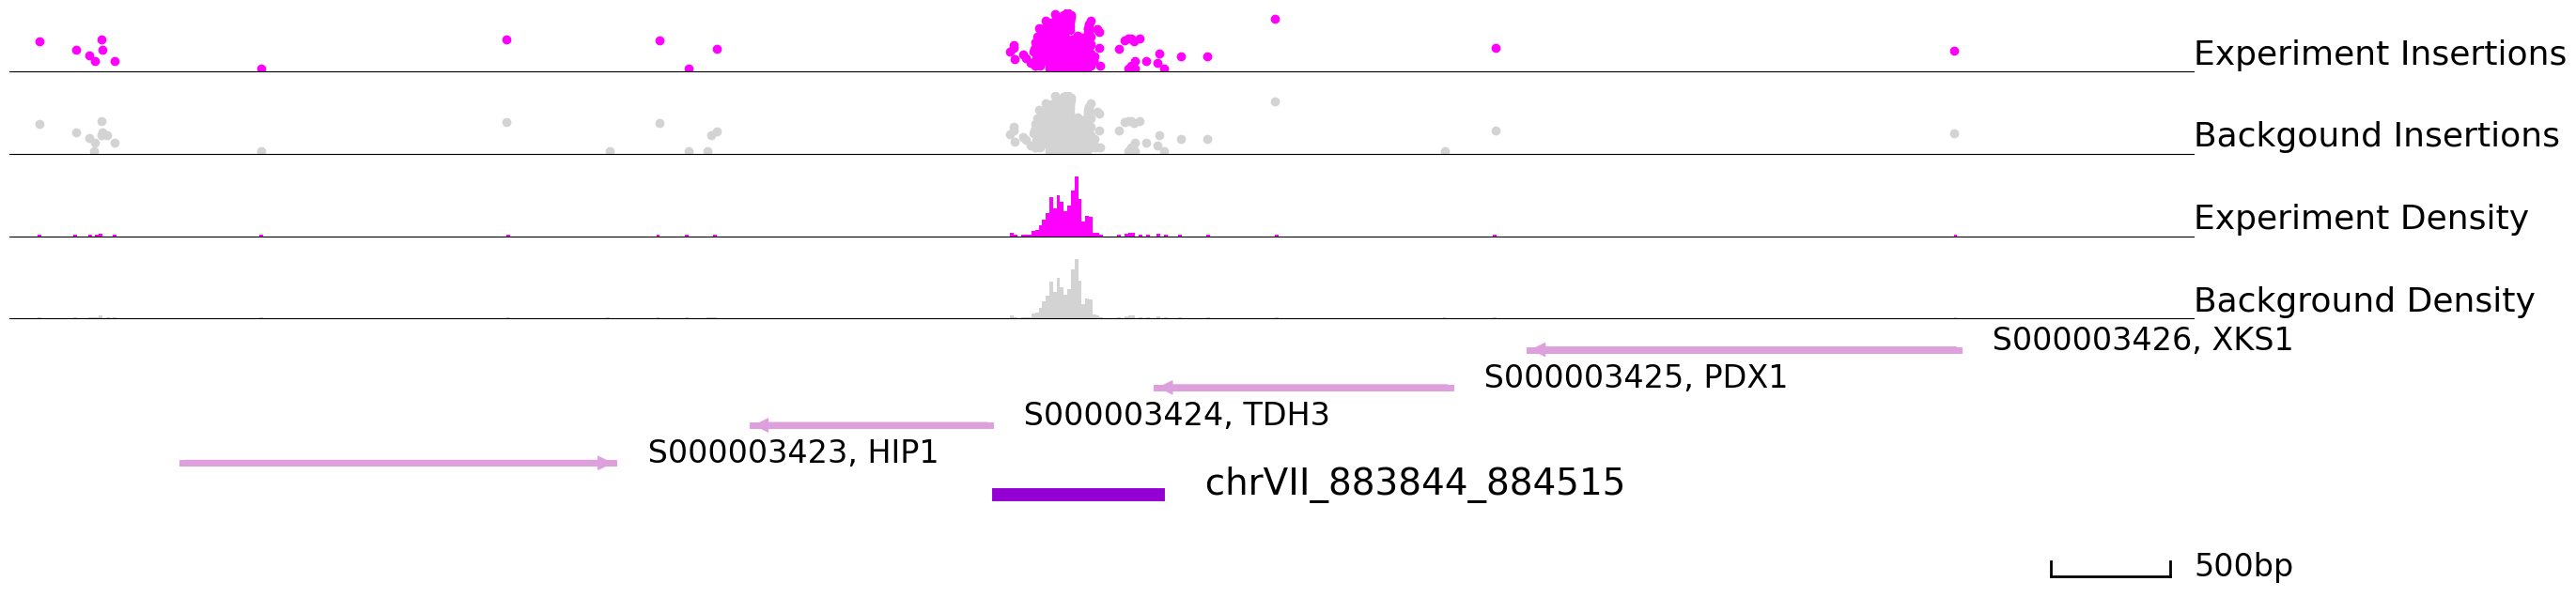

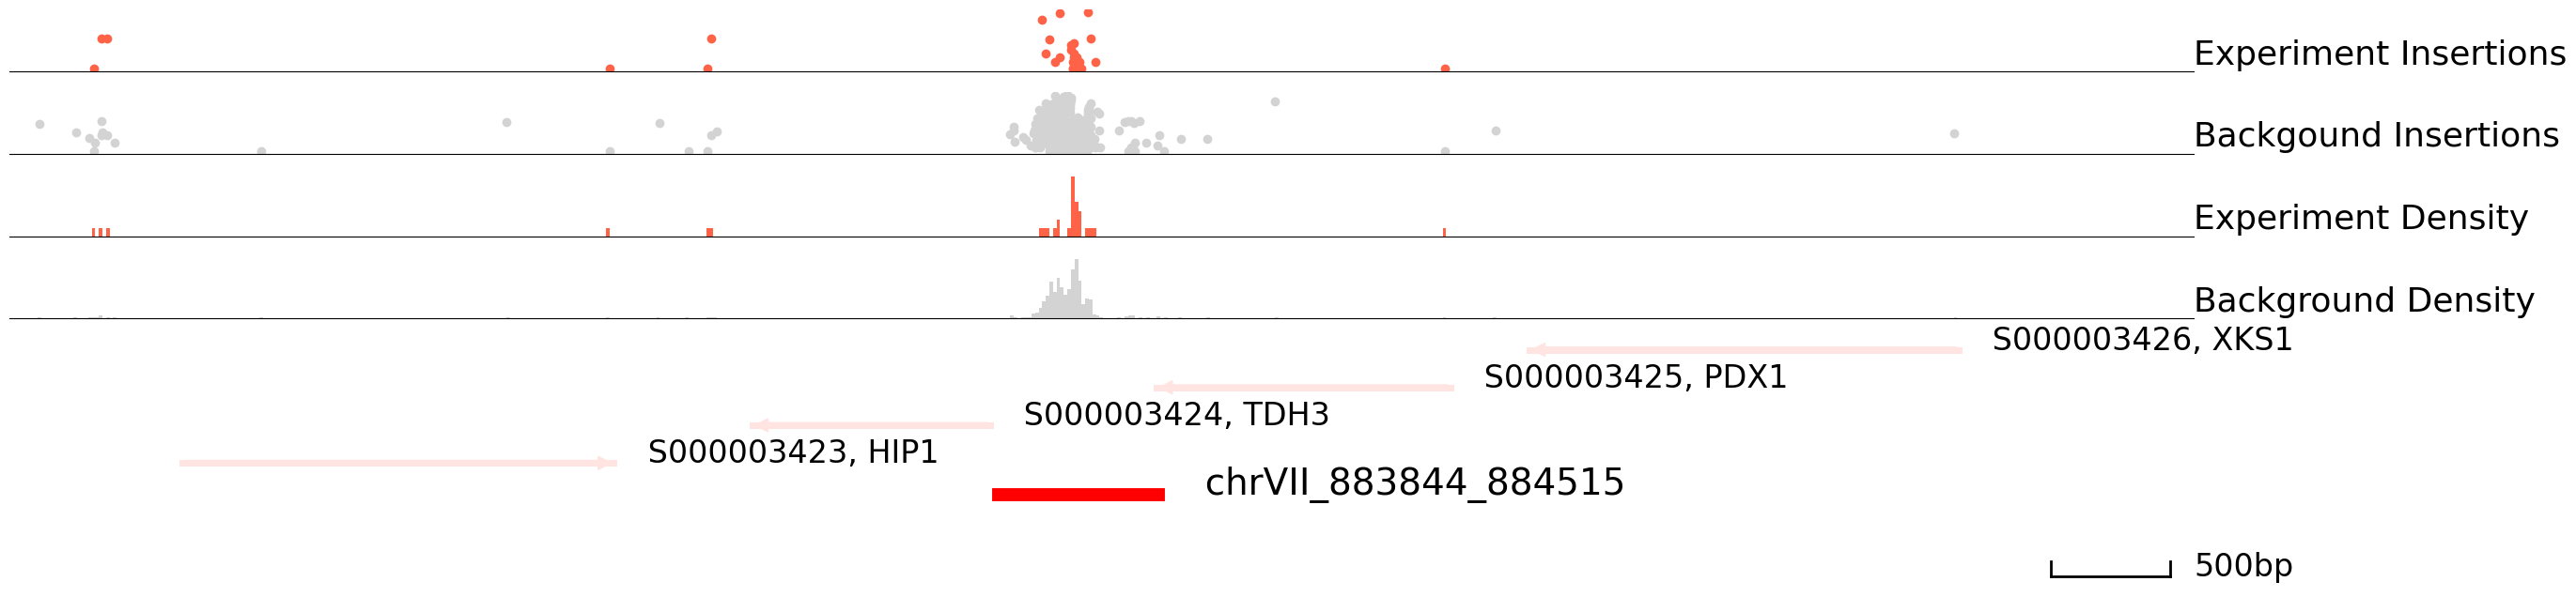

In [17]:
cc.pl.draw_area("chrVII", 883694, 884861, 4000, peak_data, qbed_data, "sacCer3", adata = adata_cc, font_size=2,
                name = "TYE7", key = "Index", insertionkey = "group", figsize = (30,8), peak_line = 1, 
                bins = 600, example_length = 500, color = "purple")
cc.pl.draw_area("chrVII", 883694, 884861, 4000, peak_data, qbed_data, "sacCer3", adata = adata_cc, font_size=2,
                name = "TYE7_gcr2ko", key = "Index", insertionkey = "group", figsize = (30,8), peak_line = 1, 
                bins = 600, example_length = 500)

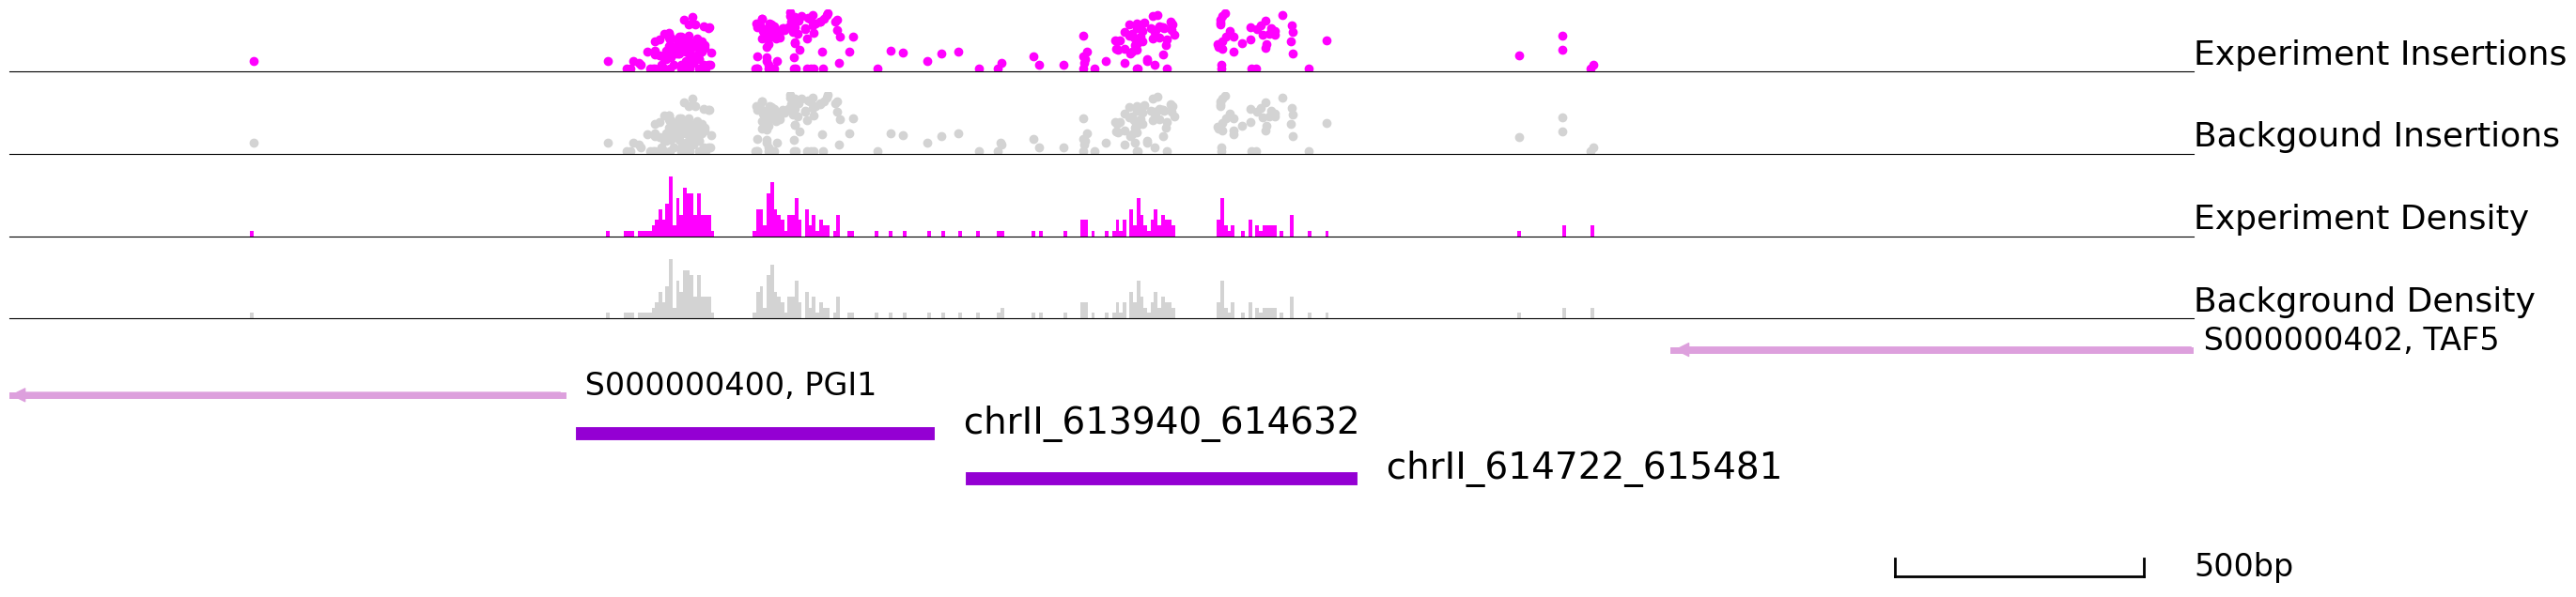

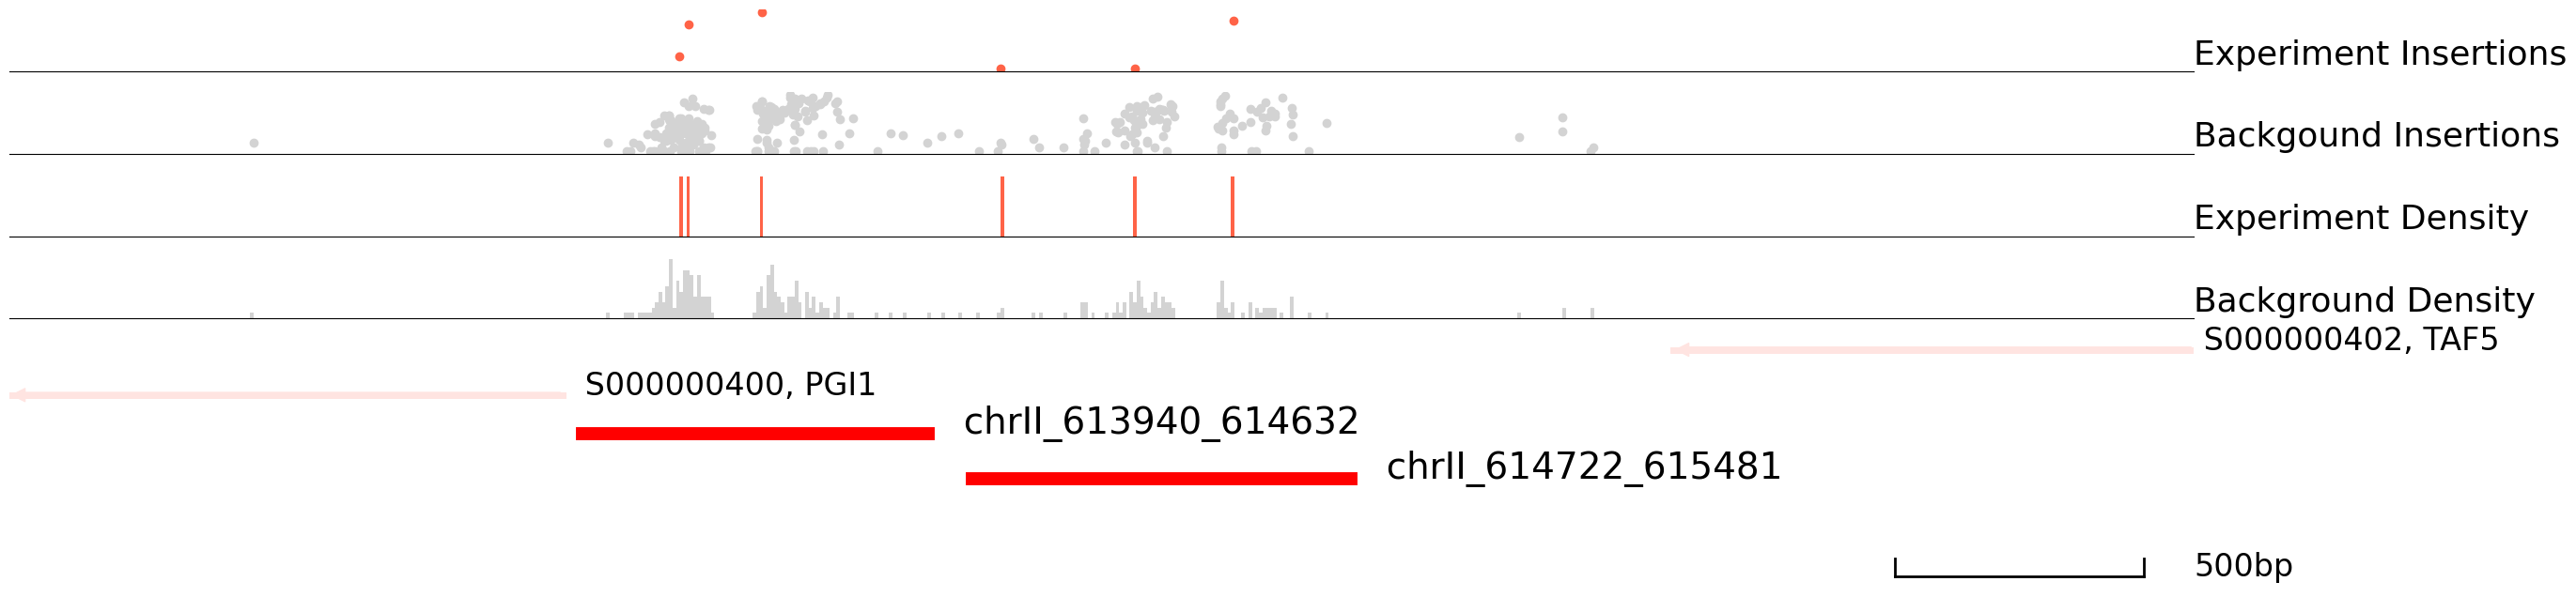

In [18]:
cc.pl.draw_area("chrII", 613790, 616171, 1000, peak_data, qbed_data, "sacCer3",adata = adata_cc, font_size = 2,
                name = "TYE7", key = "Index", insertionkey = "group", figsize = (30,8), peak_line = 2,
                bins = 600, example_length = 500, color = "purple")
cc.pl.draw_area("chrII", 613790, 616171, 1000, peak_data, qbed_data, "sacCer3", adata = adata_cc, font_size = 2,
                name = "TYE7_gcr2ko", key = "Index", insertionkey = "group", figsize = (30,8), peak_line = 2, 
                bins = 600, example_length = 500)

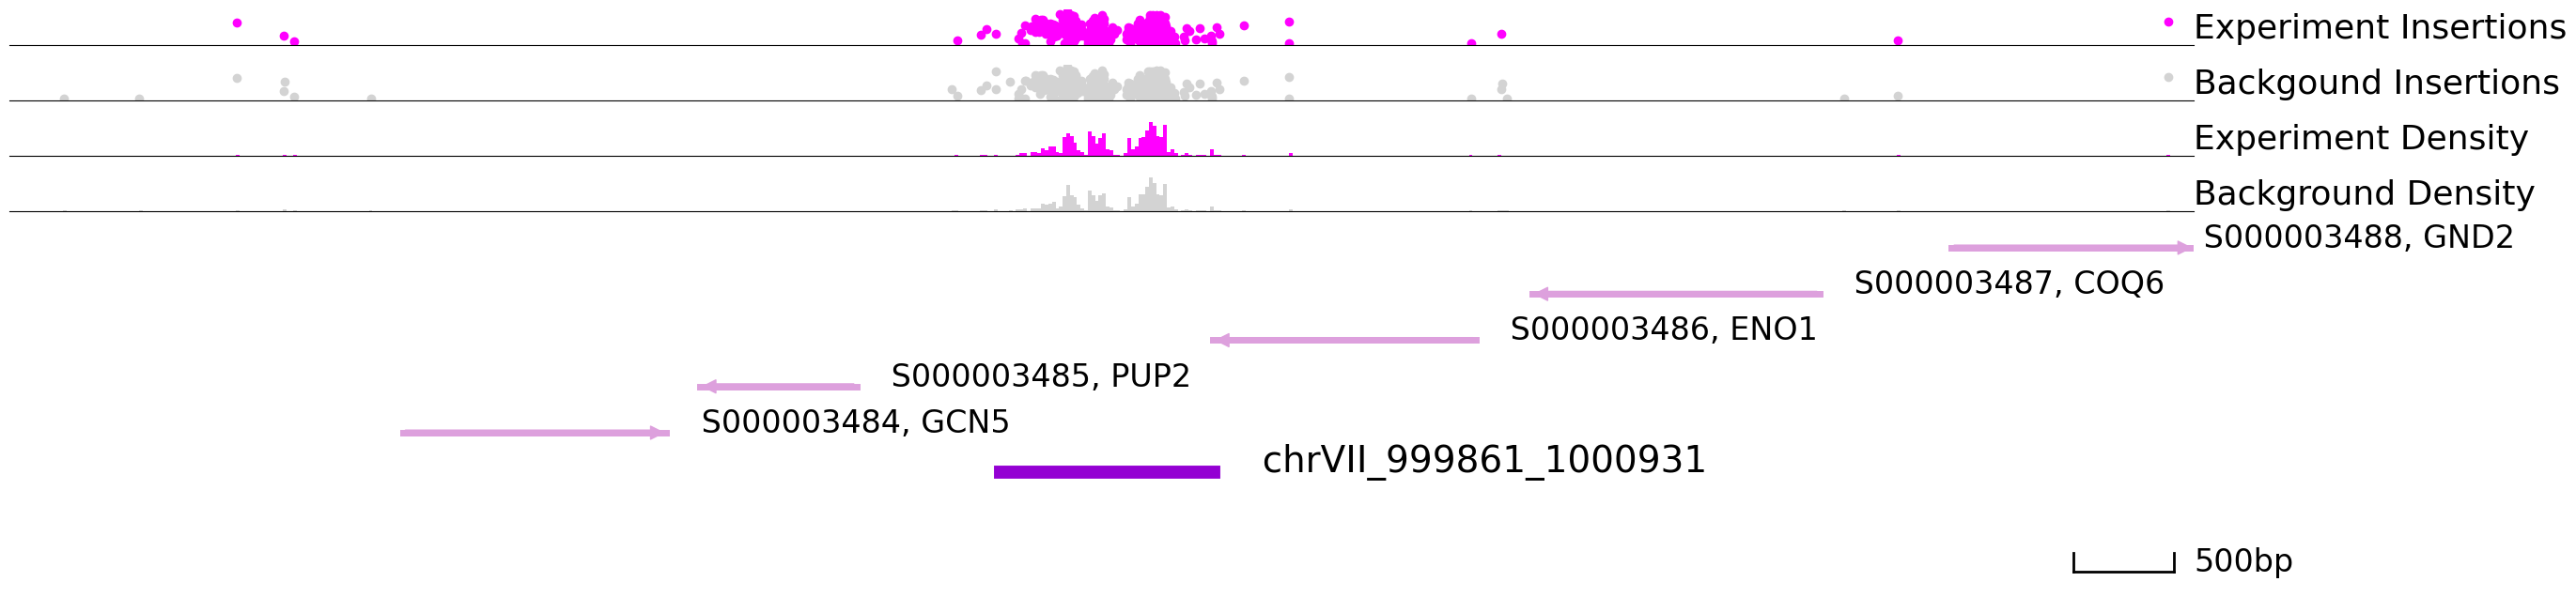

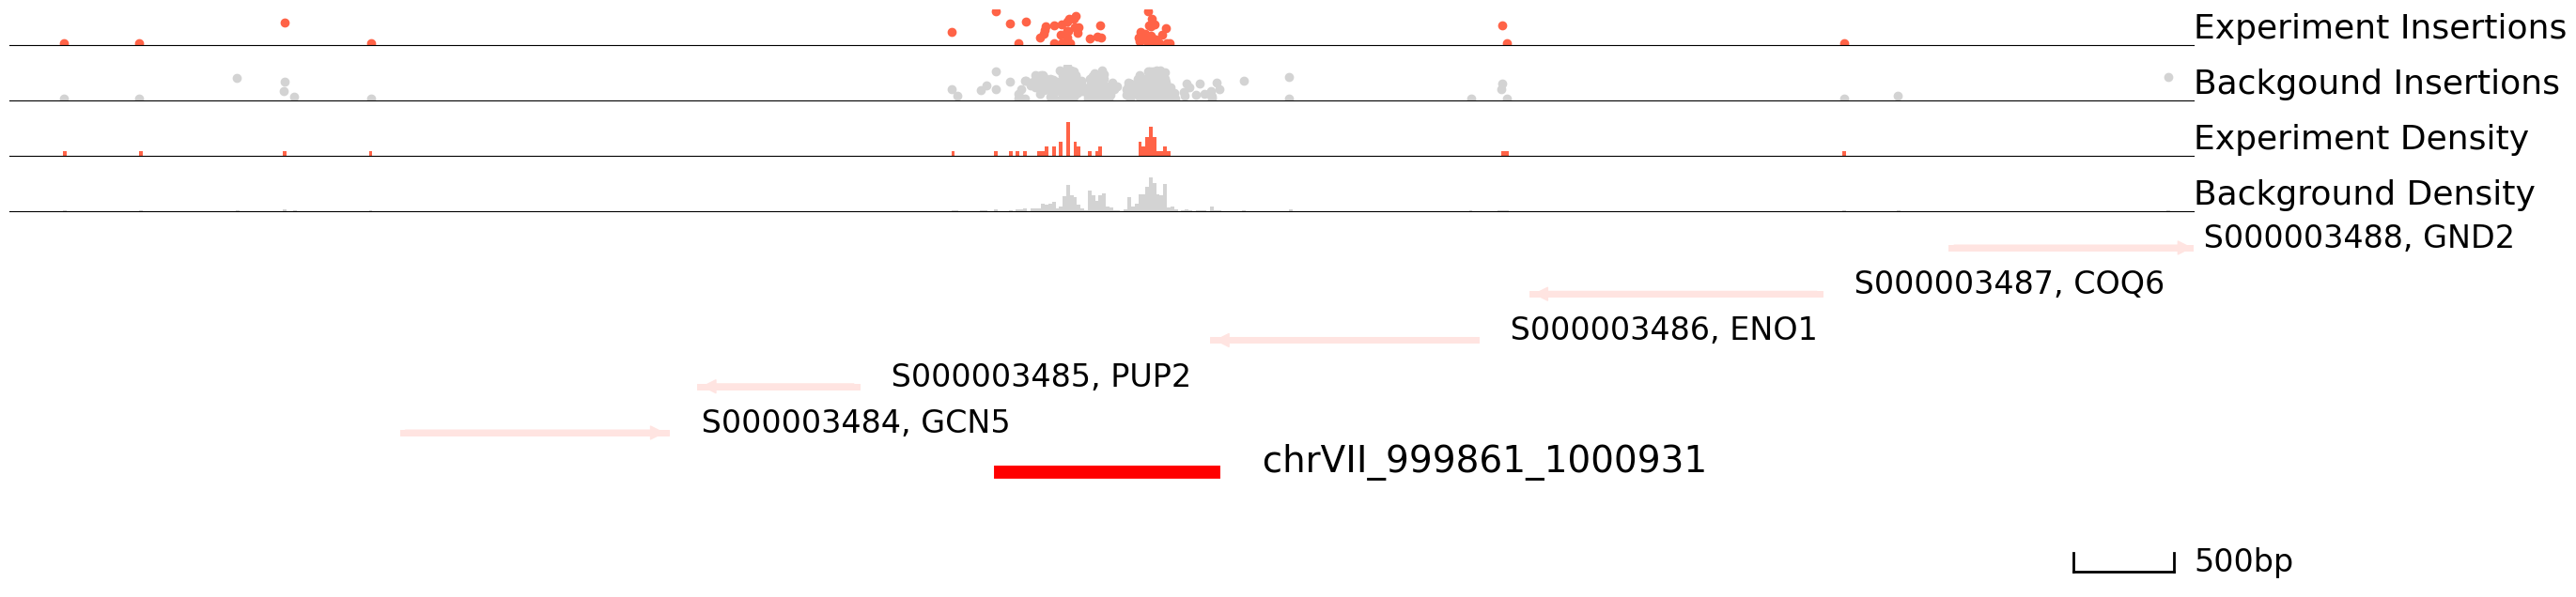

In [19]:
cc.pl.draw_area("chrVII", 999899, 1000836, 5000, peak_data, qbed_data, "sacCer3", adata = adata_cc, font_size = 2, 
                plotsize = [1,1,5], name = "TYE7", key = "Index", insertionkey = "group", figsize = (30,8), 
                peak_line = 1, bins = 600, example_length = 500, color = "purple")
cc.pl.draw_area("chrVII", 999899, 1000836, 5000, peak_data, qbed_data, "sacCer3", adata = adata_cc, font_size = 2, 
                plotsize = [1,1,5], name = "TYE7_gcr2ko", key = "Index", insertionkey = "group", figsize = (30,8), 
                peak_line = 1, bins = 600,example_length=500)

Plot the volcano plot for differential binding sites.

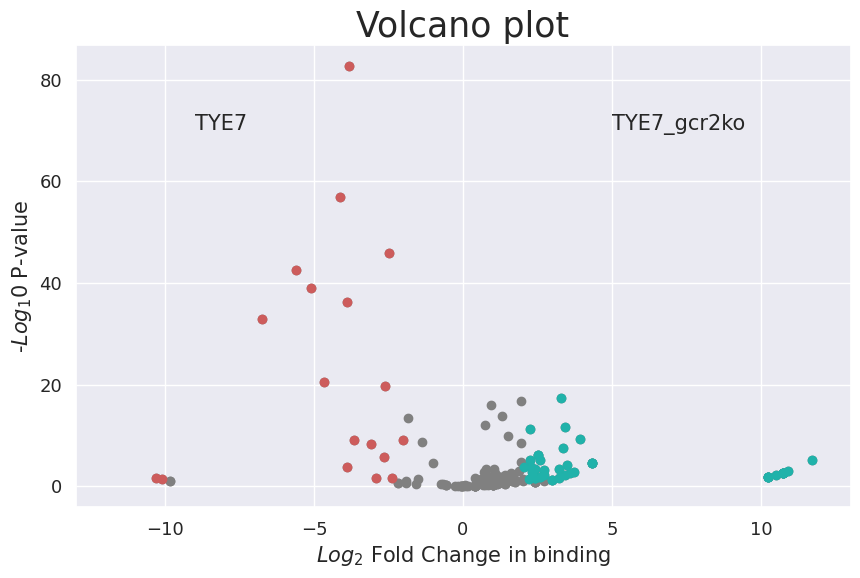

In [20]:
cc.pl.volcano_plot(adata_cc, pvalue_cutoff = 0.05, lfc_cutoff = 2, labelright = (5,70), labelleft = (-9,70))

This is the heatmap for relative calling cards bindings.

*RDM comment -- this shows several peaks where Tye7p binding increases upon gcr2 ko.  Are these real?? I would like to see them.

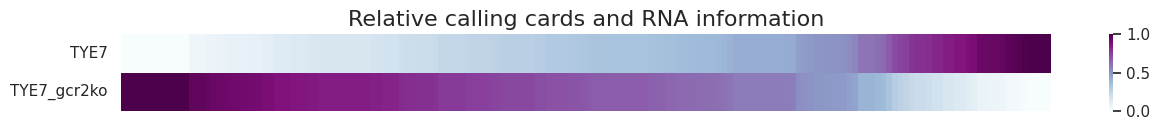

In [21]:
cc.pl.heatmap(adata_cc, figsize=(15,1))

In [22]:
adata_cc.var

,Chr,Start,End,Center,pvalue,Experiment Insertions,Reference Insertions,Fraction Experiment,TPH Experiment,Expect insertions,pvalue_adj,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2
name,,,,,,,,,,,,,,,
chrIII_1340_1530,chrIII,1340,1530,1430.5,1.558529e-07,18,19,0.000758,7.581182e+04,4.303782,0.000075,S000000574,VBA3,S000000572,HMLALPHA2
chrIII_137107_137488,chrIII,137107,137488,137374.5,1.911649e-09,24,25,0.001011,1.010824e+05,5.662871,0.000001,S000000604,ADP1,S000000605,PGK1
chrIII_168825_168975,chrIII,168825,168975,168909.0,1.545608e-07,5,1,0.000211,2.105884e+04,0.226515,0.000075,S000000622,RHB1,S000000623,FEN2
chrIII_4271_4387,chrIII,4271,4387,4323.0,1.657395e-06,11,9,0.000463,4.632944e+04,2.038634,0.000684,S000000574,VBA3,S000000572,HMLALPHA2
chrIII_50464_50773,chrIII,50464,50773,50622.0,0.000000e+00,57,17,0.002401,2.400708e+05,3.850752,0.000000,S000000545,GLK1,S000000548,PDI1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrXV_988668_988846,chrXV,988668,988846,988765.0,6.583307e-08,11,5,0.000463,4.632944e+04,1.494937,0.000035,S000005875,PUT4,S000005876,CIN1
chrXV_989350_989493,chrXV,989350,989493,989418.0,3.939311e-08,14,8,0.000590,5.896475e+04,2.391899,0.000021,S000005876,CIN1,S000005875,PUT4
chrX_337214_338085,chrX,337214,338085,337756.0,0.000000e+00,746,47,0.031420,3.141979e+06,19.565472,0.000000,S000003589,PEP8,S000003588,TDH1


In some cases, the peaks are divided into two and the gap might be acture binding sites. This often happens in yeast data because insertions can bind anywhere, but it rarely happens in human/mouse data, because it can only bind in TTAA sites.

We could perform a footprint analysis on yeast data. 

In [23]:
adata_cc.var = cc.tl.footprint(adata_cc.var, qbed_data)
adata_cc.var

,Chr,Start,End,Center,pvalue,Experiment Insertions,Reference Insertions,Fraction Experiment,TPH Experiment,Expect insertions,pvalue_adj,Nearest Refseq1,Gene Name1,Nearest Refseq2,Gene Name2,Chr_footprint,Start_footprint,End_footprint
name,,,,,,,,,,,,,,,,,,
chrIII_1340_1530,chrIII,1340,1530,1430.5,1.558529e-07,18,19,0.000758,7.581182e+04,4.303782,0.000075,S000000574,VBA3,S000000572,HMLALPHA2,chrIII,1340,1530
chrIII_137107_137488,chrIII,137107,137488,137374.5,1.911649e-09,24,25,0.001011,1.010824e+05,5.662871,0.000001,S000000604,ADP1,S000000605,PGK1,chrIII,137232,137387
chrIII_168825_168975,chrIII,168825,168975,168909.0,1.545608e-07,5,1,0.000211,2.105884e+04,0.226515,0.000075,S000000622,RHB1,S000000623,FEN2,chrIII,168825,168975
chrIII_4271_4387,chrIII,4271,4387,4323.0,1.657395e-06,11,9,0.000463,4.632944e+04,2.038634,0.000684,S000000574,VBA3,S000000572,HMLALPHA2,chrIII,4271,4387
chrIII_50464_50773,chrIII,50464,50773,50622.0,0.000000e+00,57,17,0.002401,2.400708e+05,3.850752,0.000000,S000000545,GLK1,S000000548,PDI1,chrIII,50528,50645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chrXV_988668_988846,chrXV,988668,988846,988765.0,6.583307e-08,11,5,0.000463,4.632944e+04,1.494937,0.000035,S000005875,PUT4,S000005876,CIN1,chrXV,988668,988846
chrXV_989350_989493,chrXV,989350,989493,989418.0,3.939311e-08,14,8,0.000590,5.896475e+04,2.391899,0.000021,S000005876,CIN1,S000005875,PUT4,chrXV,989350,989493
chrX_337214_338085,chrX,337214,338085,337756.0,0.000000e+00,746,47,0.031420,3.141979e+06,19.565472,0.000000,S000003589,PEP8,S000003588,TDH1,chrX,337626,337820


Above is the footprint data saved in adata_cc. Here we do it again and perserve it in bed data.

In [24]:
footprint_bed = cc.tl.footprint(peak_data, qbed_data, return_bed = True, delete_unfound = True)
footprint_bed[0:10]

/scratch/rmlab/rmlab_shared/g.juanru/pycallingcards/pycallingcards/pycallingcards/tools/_footprint.py:118: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  result.iloc[:, 1:3] = result.iloc[:, 1:3].astype(int)


,Chr_footprint,Start_footprint,End_footprint
0,chrI,68259,68644
1,chrI,71210,71407
4,chrI,229792,229931
5,chrII,30129,30410
7,chrII,221449,221557
8,chrII,260504,260581
11,chrII,455557,455688
12,chrII,533361,533486
13,chrII,614132,614363
14,chrII,615046,615293


Let's visulize part of the footprint points.

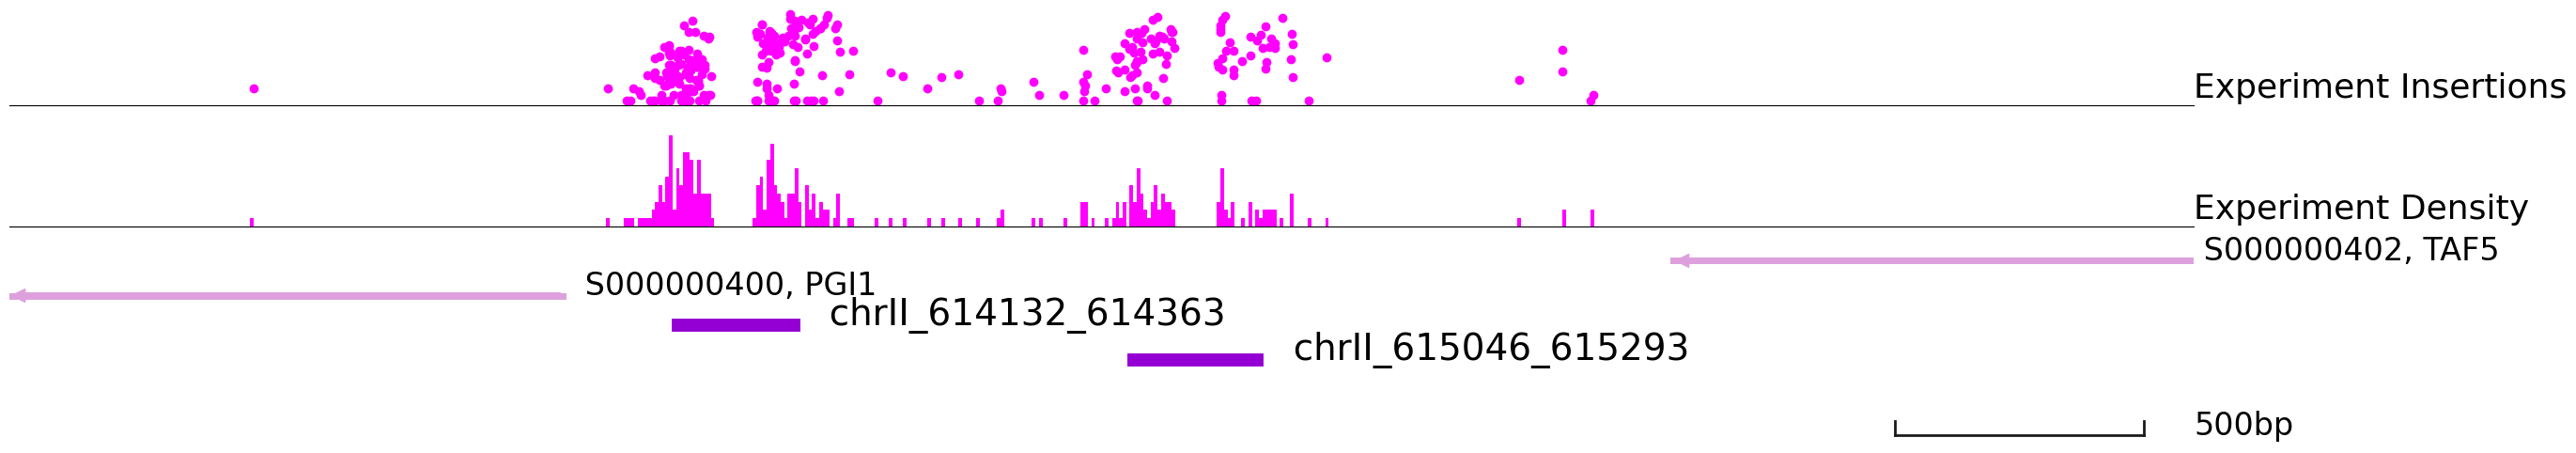

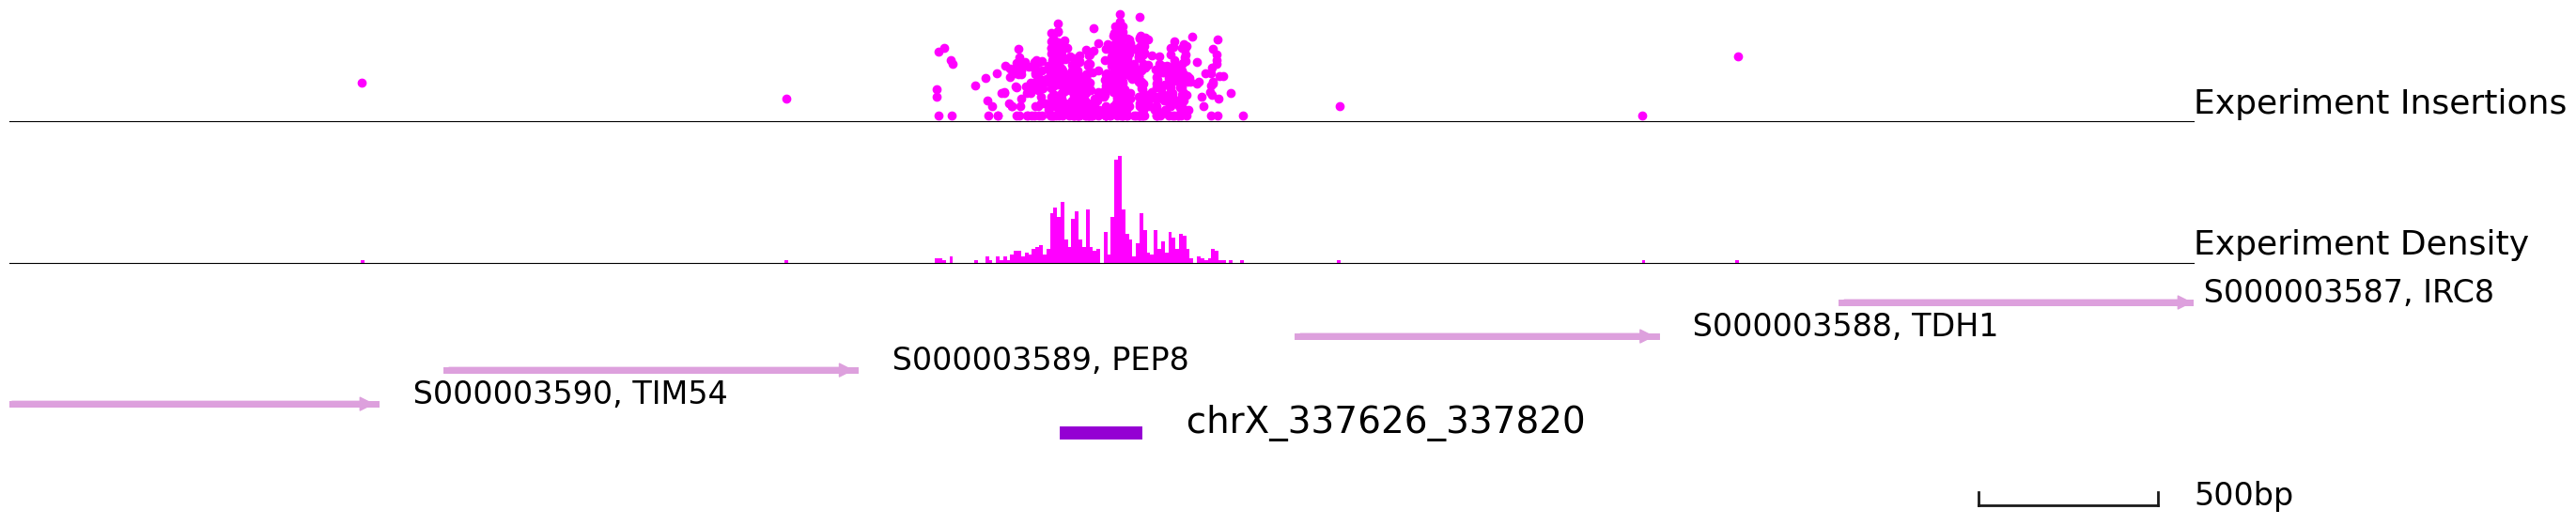

In [25]:
cc.pl.draw_area("chrII", 613790, 616171, 1000, footprint_bed, qbed_data, "sacCer3", font_size=2,
                key = "Index", insertionkey = "group", figsize = (30,6), peak_line = 2, bins = 600, 
                example_length = 500, color = "purple")
cc.pl.draw_area("chrX", 337680, 337768, 3000, footprint_bed, qbed_data, "sacCer3", font_size=2,
                key = "Index", insertionkey = "group", figsize = (30,7), peak_line = 1, bins = 600, 
                example_length = 500, color = "purple")

Saved the file if needed.

In [26]:
adata_cc.write("yeast.h5ad")